# Cells Instance Segmentation: Starter Notebook Using Mask-RCNN

## 📘 Notebook Overview

1. **Setup & Config**  
   - Fixes random seeds for reproducibility  
   - Defines paths, image dimensions, device, and hyperparameters  

2. **Augmentations & RLE Utils**  
   - Augmentations pipelines for training and test using Albumentations  
   - RLE decode/encode functions and overlap removal  

3. **Datasets & DataLoaders**  
   - `CellDataset` for training/validation (with masks + boxes)  
   - `CellTestDataset` for inference  
   - PyTorch DataLoaders with custom collate functions  

4. **Model**  
   - Mask R-CNN with ResNet-50 FPN backbone  
   - Custom heads for 2 classes (background + cell)
     

5. **Training & Validation**  
   - training loop with mask & total loss logging  
   - Validation run per epoch and checkpoint saving  
   - Selects best model based on val loss  

6. **Inference & Submission**  
   - Runs test predictions  
   - Filters and binarizes masks, removes overlaps  
   - Encodes masks as RLE and generates `submission.csv`

# Imports

In [32]:
import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [33]:
# Fix randomness
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2025)

## Configuration

In [34]:
TRAIN_CSV = "/kaggle/input/kaust-vs-kku-tournament-round-3/cells_segmentation/train.csv"
TRAIN_PATH = "/kaggle/input/kaust-vs-kku-tournament-round-3/cells_segmentation/train"
TEST_PATH = "/kaggle/input/kaust-vs-kku-tournament-round-3/cells_segmentation/test"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Data Hyperparameters
WIDTH = 704     # Same as original datasets images size ---> Important in segmentation tasks
HEIGHT = 520
PCT_IMAGES_VALIDATION = 0.075   # 7.5% val, 92.5% training

#### Modeling Hyperparameters
BATCH_SIZE = 2
NUM_EPOCHS = 3
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0005
BOX_DETECTIONS_PER_IMG = 512  # maximum number of detections per image

#### Inference Hyperparameters
BOXES_CONF = 0.3  # 0 = keeps all boxes
MASK_THRESHOLD = 0.5   # Threshold for binarizing the masks


# Augmentations

In [35]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transform(train=True, height=HEIGHT, width=WIDTH):
    if train:
        return A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ColorJitter(p=0.3),
                A.Resize(height, width),
                A.Normalize(),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
        )
    else:
        return A.Compose(
            [
                A.Resize(height, width),
                A.Normalize(),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
        )

## Training Dataset and DataLoader

In [36]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [37]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.height = HEIGHT
        self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': row["annotation"]
                    }
    
    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        info = self.image_info[idx]
        # 1) Load image
        img = Image.open(info['image_path']).convert("RGB")
        img_np = np.array(img)  # H x W x 3

        # 2) Decode masks & boxes
        masks = []
        boxes = []
        for rle in info['annotations']:
            # decode to HxW bool array
            mask = rle_decode(rle, (HEIGHT, WIDTH)).astype('uint8')
            masks.append(mask)
            # get bounding box from resized mask or original
            boxes.append(self.get_box(mask))

        # dummy labels all = 1
        labels = [1] * len(masks)

        # 3) Apply Albumentations transforms (if any)
        if self.transforms:
            augmented = self.transforms(
                image=img_np,
                masks=masks,
                bboxes=boxes,
                labels=labels
            )
            img = augmented['image']                        # Tensor, CxHxW
            masks = [torch.as_tensor(m, dtype=torch.uint8) for m in augmented['masks']]
            boxes = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(augmented['labels'], dtype=torch.int64)
        else:
            # fallback to simple tensor conversion
            img = ToTensor()(img_np)
            masks = [torch.as_tensor(m, dtype=torch.uint8) for m in masks]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # 4) Build target dict
        masks = torch.stack(masks)  # N x H x W
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        return img, target

    def __len__(self):
        return len(self.image_info)

In [38]:
# class CellDataset(Dataset):
#     def __init__(self, image_dir, df, transforms=None):
#         self.transforms = transforms
#         self.image_dir = image_dir
#         self.df = df
#         self.height = HEIGHT
#         self.width = WIDTH

#         self.image_info = collections.defaultdict(dict)
#         temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
#         for index, row in temp_df.iterrows():
#             self.image_info[index] = {
#                 'image_id': row['id'],
#                 'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
#                 'annotations': row["annotation"]
#             }

#     def get_box(self, a_mask):
#         '''Get the bounding box of a given mask'''
#         pos = np.where(a_mask)
#         if len(pos[0]) == 0 or len(pos[1]) == 0:
#             return None
#         xmin = np.min(pos[1])
#         xmax = np.max(pos[1])
#         ymin = np.min(pos[0])
#         ymax = np.max(pos[0])
#         return [xmin, ymin, xmax, ymax]

#     def __getitem__(self, idx):
#         info = self.image_info[idx]
#         img = Image.open(info['image_path']).convert("RGB")
#         img_np = np.array(img)

#         masks = []
#         boxes = []
#         for rle in info['annotations']:
#             mask = rle_decode(rle, (self.height, self.width)).astype('uint8')
#             img = img.resize((352, 260))
#             box = self.get_box(mask)
#             if box is None:
#                 continue
#             masks.append(mask)
#             boxes.append(box)

#         if len(masks) == 0:
#             # Avoid crashing if no valid masks/boxes
#             masks = [np.zeros((self.height, self.width), dtype=np.uint8)]
#             boxes = [[0, 0, 1, 1]]
#             labels = [0]
#         else:
#             labels = [1] * len(masks)

#         if self.transforms:
#             augmented = self.transforms(
#                 image=img_np,
#                 masks=masks,
#                 bboxes=boxes,
#                 labels=labels
#             )
#             img = augmented['image']
#             masks = [torch.as_tensor(m, dtype=torch.uint8) for m in augmented['masks']]
#             boxes = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
#             labels = torch.as_tensor(augmented['labels'], dtype=torch.int64)
#         else:
#             img = ToTensor()(img_np)
#             masks = [torch.as_tensor(m, dtype=torch.uint8) for m in masks]
#             boxes = torch.as_tensor(boxes, dtype=torch.float32)
#             labels = torch.as_tensor(labels, dtype=torch.int64)

#         masks = torch.stack(masks)
#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)

#         target = {
#             'boxes': boxes,
#             'labels': labels,
#             'masks': masks,
#             'image_id': image_id,
#             'area': area,
#             'iscrowd': iscrowd
#         }

#         return img, target

#     def __len__(self):
#         return len(self.image_info)

In [39]:
# import os
# import collections
# import numpy as np
# from PIL import Image
# import torch
# from torch.utils.data import Dataset
# from torchvision.transforms import ToTensor

# class CellDataset(Dataset):
#     def __init__(self, image_dir, df, transforms=None):
#         self.transforms = transforms
#         self.image_dir = image_dir
#         self.df = df
#         self.height = HEIGHT
#         self.width = WIDTH

#         self.image_info = collections.defaultdict(dict)
#         temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
#         for index, row in temp_df.iterrows():
#             self.image_info[index] = {
#                 'image_id': row['id'],
#                 'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
#                 'annotations': row["annotation"]
#             }

#     def get_box(self, a_mask):
#         '''Get the bounding box of a given mask'''
#         pos = np.where(a_mask)
#         if len(pos[0]) == 0 or len(pos[1]) == 0:
#             return None
#         xmin = np.min(pos[1])
#         xmax = np.max(pos[1])
#         ymin = np.min(pos[0])
#         ymax = np.max(pos[0])
#         return [xmin, ymin, xmax, ymax]

#     def __getitem__(self, idx):
#         info = self.image_info[idx]

#         # 1) Load and resize image to match mask shape
#         img = Image.open(info['image_path']).convert("RGB")
#         img = img.resize((self.width, self.height))  # (W, H)
#         img_np = np.array(img)

#         # 2) Decode masks and compute boxes
#         masks = []
#         boxes = []
#         for rle in info['annotations']:
#             mask = rle_decode(rle, (self.height, self.width)).astype('uint8')
#             box = self.get_box(mask)
#             if box is None:
#                 continue
#             masks.append(mask)
#             boxes.append(box)

#         # 3) Handle edge case: no valid masks
#         if len(masks) == 0:
#             masks = [np.zeros((self.height, self.width), dtype=np.uint8)]
#             boxes = [[0, 0, 1, 1]]
#             labels = [0]
#         else:
#             labels = [1] * len(masks)

#         # 4) Apply Albumentations transforms
#         if self.transforms:
#             augmented = self.transforms(
#                 image=img_np,
#                 masks=masks,
#                 bboxes=boxes,
#                 labels=labels
#             )
#             img = augmented['image']
#             masks = [torch.as_tensor(m, dtype=torch.uint8) for m in augmented['masks']]
#             boxes = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
#             labels = torch.as_tensor(augmented['labels'], dtype=torch.int64)
#         else:
#             img = ToTensor()(img_np)
#             masks = [torch.as_tensor(m, dtype=torch.uint8) for m in masks]
#             boxes = torch.as_tensor(boxes, dtype=torch.float32)
#             labels = torch.as_tensor(labels, dtype=torch.int64)

#         # 5) Pack target dictionary
#         masks = torch.stack(masks)  # (N, H, W)
#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)

#         target = {
#             'boxes': boxes,
#             'labels': labels,
#             'masks': masks,
#             'image_id': image_id,
#             'area': area,
#             'iscrowd': iscrowd
#         }

#         return img, target

#     def __len__(self):
#         return len(self.image_info)

# Split Data
#### (group on "id" to ensure different images between train and val)

In [40]:
from sklearn.model_selection import train_test_split


df_base = pd.read_csv(TRAIN_CSV)

# ------------------------------------------------------------------
# 1)  Split the unique IDs (groups) – no stratification.
# ------------------------------------------------------------------
unique_ids = df_base['id'].unique()                     
train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=PCT_IMAGES_VALIDATION,
    random_state=42,      
    shuffle=True          
)

# ------------------------------------------------------------------
# 2)  Slice the image-level DataFrame with those IDs.
# ------------------------------------------------------------------
df_train = df_base[df_base['id'].isin(train_ids)]
df_val   = df_base[df_base['id'].isin(val_ids)]

# ------------------------------------------------------------------
# 4)  Quick sanity check.
# ------------------------------------------------------------------
print(f"Images in train set:           {len(train_ids):,}")
print(f"Annotations in train set:           {len(df_train):,}")
print(f"Images in validation set:      {len(val_ids):,}")
print(f"Annotations in validation set:      {len(df_val):,}")


Images in train set:           392
Annotations in train set:           50,275
Images in validation set:      32
Annotations in validation set:      2,790


In [41]:
pip install -U albumentations

Note: you may need to restart the kernel to use updated packages.


In [42]:
ds_train = CellDataset(TRAIN_PATH, df_train, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

ds_val = CellDataset(TRAIN_PATH, df_val, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, 
                    num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

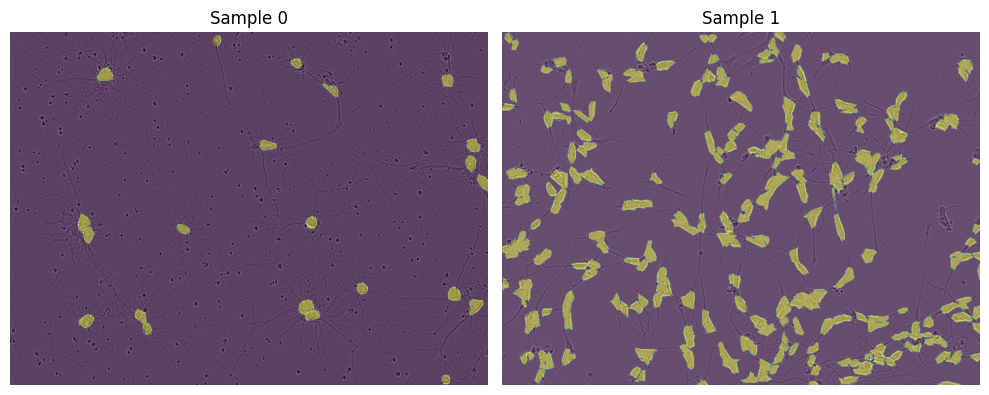

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import math

def show_augmented_batch(
    dataloader, 
    num_images=4, 
    mask_alpha=0.4, 
    mean=(0.485, 0.456, 0.406), 
    std=(0.229, 0.224, 0.225)
):
    """
    Grab one batch from `dataloader` and plot up to `num_images`
    images with their combined mask overlays.
    Assumes your transforms used A.Normalize(mean, std).
    """
    images, targets = next(iter(dataloader))
    batch_size = len(images)
    n_show = min(num_images, batch_size)
    
    cols = 2
    rows = math.ceil(n_show / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()
    
    for i in range(n_show):
        # 1) Un-normalize
        img_t = images[i].cpu().clone()  # C×H×W tensor
        for c in range(3):
            img_t[c] = img_t[c] * std[c] + mean[c]
        img_np = img_t.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        # 2) Combine masks
        combined_mask = np.zeros(img_np.shape[:2], dtype=bool)
        for m in targets[i]['masks']:
            arr = m.cpu().numpy()
            if arr.ndim == 3: 
                arr = arr.squeeze(0)
            combined_mask = np.logical_or(combined_mask, arr.astype(bool))
        
        # 3) Plot
        ax = axes[i]
        ax.imshow(img_np)
        ax.imshow(combined_mask, alpha=mask_alpha)
        ax.set_title(f"Sample {i}")
        ax.axis('off')
    
    # hide extra subplots
    for j in range(n_show, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmented_batch(dl_train, num_images=BATCH_SIZE)

# Training

## Model

In [44]:
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_stronger_model():
    NUM_CLASSES = 2  # Background + 1 class (e.g. cell)

    # 🔥 Stronger backbone: ResNet-50 + FPN
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)

    # Build the Mask R-CNN model with the backbone
    model = MaskRCNN(backbone, num_classes=NUM_CLASSES)

    # Optional: fine-tune the mask head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)

    return model

# Instantiate and move to device
model = get_stronger_model()
model.to(DEVICE)
model.train()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

## Training loop

In [45]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [46]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import time
import numpy as np
import cv2

# --- Morphological Postprocessing ---
def postprocess_mask(mask_tensor):
    mask = mask_tensor.cpu().numpy().astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)

    # Opening: remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Closing: fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return torch.tensor(mask, dtype=torch.float32, device=mask_tensor.device)

# --- BCE Loss Only ---
def bce_loss_only(pred_mask_logits, true_masks):
    return F.binary_cross_entropy_with_logits(pred_mask_logits, true_masks.float())

# --- Dice Score ---
def dice_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + eps) / (union + eps)

# --- Optimizer, Scheduler, AMP ---
scaler = GradScaler()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

n_batches = len(dl_train)
n_batches_val = len(dl_val)
validation_losses = []

# --- Training Loop ---
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n🔁 Starting epoch {epoch} of {NUM_EPOCHS}")
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    model.train()
    pbar = tqdm(enumerate(dl_train, 1), total=n_batches, desc=f"🚂 Train Epoch {epoch}", ncols=120)
    for batch_idx, (images, targets) in pbar:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            loss_dict = model(images, targets)
            loss = sum(v for k, v in loss_dict.items() if k != 'loss_mask')

        model.eval()
        with torch.no_grad():
            preds = model(images)
        model.train()

        pred_masks = preds[0]['masks'].squeeze(1)
        pred_binary = (torch.sigmoid(pred_masks) > 0.5).float().sum(0).clamp(0, 1).unsqueeze(0)

        true_masks = targets[0]['masks'].float()
        true_binary = true_masks.sum(0).clamp(0, 1).unsqueeze(0)

        mask_loss = bce_loss_only(pred_binary, true_binary)
        total_loss = loss + 1.5 * mask_loss

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        del images, targets, preds, pred_masks, pred_binary, true_masks, true_binary
        torch.cuda.empty_cache()

        loss_accum += total_loss.item()
        loss_mask_accum += mask_loss.item()

        pbar.set_postfix({
            "Loss": f"{total_loss.item():.3f}",
            "MaskLoss": f"{mask_loss.item():.3f}",
            "AvgLoss": f"{loss_accum / batch_idx:.3f}",
            "AvgMask": f"{loss_mask_accum / batch_idx:.3f}"
        })

    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches

    # --- Validation Loop ---
    val_loss_accum = 0.0
    val_loss_mask_accum = 0.0
    dice_accum = 0.0

    model.eval()
    with torch.no_grad():
        pbar = tqdm(enumerate(dl_val, 1), total=n_batches_val, desc=f"🧪 Val   Epoch {epoch}", ncols=120)
        for batch_idx, (images, targets) in pbar:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            preds = model(images)

            pred_masks = preds[0]['masks'].squeeze(1)
            pred_binary = (torch.sigmoid(pred_masks) > 0.5).float().sum(0).clamp(0, 1).unsqueeze(0)

            # ✅ Apply postprocessing to clean up the predicted binary mask
            pred_binary[0] = postprocess_mask(pred_binary[0])

            true_masks = targets[0]['masks'].float()
            true_binary = true_masks.sum(0).clamp(0, 1).unsqueeze(0)

            mask_loss = bce_loss_only(pred_binary, true_binary)
            dice = dice_score(pred_binary, true_binary)
            total_loss = mask_loss

            val_loss_accum += total_loss.item()
            val_loss_mask_accum += mask_loss.item()
            dice_accum += dice.item()

            del images, targets, preds, pred_masks, pred_binary, true_masks, true_binary
            torch.cuda.empty_cache()

            pbar.set_postfix({
                "ValLoss": f"{total_loss.item():.3f}",
                "AvgValLoss": f"{val_loss_accum / batch_idx:.3f}",
                "AvgValMask": f"{val_loss_mask_accum / batch_idx:.3f}",
                "Dice": f"{dice.item():.3f}"
            })

    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    avg_dice = dice_accum / n_batches_val
    elapsed = time.time() - time_start
    validation_losses.append(val_loss)

    scheduler.step(val_loss)
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")

    print(f"\n✅ [Epoch {epoch:2d}/{NUM_EPOCHS:2d}] "
          f"Train Loss: {train_loss:.3f} | Mask: {train_loss_mask:.3f} || "
          f"Val Loss: {val_loss:.3f} | Mask: {val_loss_mask:.3f} | Dice: {avg_dice:.3f} || "
          f"⏱ Elapsed: {elapsed:.1f}s")


🔁 Starting epoch 1 of 3


/tmp/ipykernel_36/2527018888.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
🚂 Train Epoch 1:   0%|                                                                         | 0/196 [00:00<?, ?it/s]/tmp/ipykernel_36/2527018888.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🧪 Val   Epoch 1: 100%|██| 16/16 [00:08<00:00,  1.90it/s, ValLoss=0.796, AvgValLoss=0.761, AvgValMask=0.761, Dice=0.313]



✅ [Epoch  1/ 3] Train Loss: 2.741 | Mask: 0.771 || Val Loss: 0.761 | Mask: 0.761 | Dice: 0.321 || ⏱ Elapsed: 158.4s

🔁 Starting epoch 2 of 3


🧪 Val   Epoch 2: 100%|██| 16/16 [00:07<00:00,  2.02it/s, ValLoss=0.736, AvgValLoss=0.733, AvgValMask=0.733, Dice=0.281]



✅ [Epoch  2/ 3] Train Loss: 2.548 | Mask: 0.746 || Val Loss: 0.733 | Mask: 0.733 | Dice: 0.371 || ⏱ Elapsed: 154.1s

🔁 Starting epoch 3 of 3


🧪 Val   Epoch 3: 100%|██| 16/16 [00:08<00:00,  1.91it/s, ValLoss=0.717, AvgValLoss=0.713, AvgValMask=0.713, Dice=0.404]



✅ [Epoch  3/ 3] Train Loss: 2.460 | Mask: 0.740 || Val Loss: 0.713 | Mask: 0.713 | Dice: 0.486 || ⏱ Elapsed: 157.8s


# Inference

## Test Dataset and DataLoader

In [54]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        # strip off “.png” to leave only the ID
        self.image_ids = [fname[:-4] for fname in os.listdir(self.image_dir) 
                          if fname.endswith('.png')]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)   # H×W×3

        if self.transforms:
            # Albumentations returns a dict
            augmented = self.transforms(image=img_np, bboxes=[], labels=[])
            img_tensor = augmented['image']
        else:
            # fallback: convert PIL→Tensor yourself
            from torchvision.transforms import ToTensor
            img_tensor = ToTensor()(img)

        return {'image': img_tensor, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

ds_test = CellTestDataset(
    TEST_PATH,
    transforms=get_transform(train=False)  
)

test_loader = DataLoader(
    ds_test,
    batch_size=1,            
    shuffle=False,
    num_workers=2,
    collate_fn=lambda x: x   
)


In [55]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

## Load the model with lowest val_loss

In [63]:
# Epochs with their losses
print(dict((enumerate([round(v, 4) for v in validation_losses]))))
best_epoch = 10
print(f"Epoch with lowest val_loss: {best_epoch}")

{0: 0.7614, 1: 0.7332, 2: 0.7128}
Epoch with lowest val_loss: 10


In [57]:
model_chk = f"pytorch_model-e{best_epoch}.bin"
model = get_stronger_model()
model.load_state_dict(torch.load(model_chk))
model = model.to(DEVICE)
model.eval();

## Run predictions

In [58]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import torch

submission = []

# 2) Inference loop
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        sample = batch[0]           # since batch_size=1
        img       = sample['image'].to(DEVICE)
        image_id  = sample['image_id']
        
        # run one-image batch
        outputs = model([img])[0]

        # track whether we added at least one mask
        any_mask = False
        
        # iterate masks + scores
        prev_masks = []
        for mask, score in zip(outputs['masks'], outputs['scores']):
            score = score.item()
            if score < BOXES_CONF:
                continue
            any_mask = True

            mask_np = mask.cpu().numpy()
            bin_mask = mask_np[0] > MASK_THRESHOLD       # shape H×W boolean

            # remove overlaps 
            bin_mask = remove_overlapping_pixels(bin_mask, prev_masks)
            prev_masks.append(bin_mask)

            # encode and append
            rle = rle_encoding(bin_mask)
            submission.append((image_id, rle))

        # if no masks passed the score threshold, record -1
        if not any_mask:
            submission.append((image_id, "-1"))

# 3) Write out
df_sub = pd.DataFrame(submission, columns=['id','annotation'])
df_sub["idx"] = range(len(df_sub))
df_sub = df_sub[["idx","id","annotation"]].replace({"":"-1"})
df_sub.to_csv("submission.csv", index=False)
print(df_sub.head())


Inference: 100%|██████████| 182/182 [03:38<00:00,  1.20s/it]

   idx            id                                         annotation
0    0  8bd09ff70b13                    24314 5 25021 2 33468 1 34172 1
1    1  8bd09ff70b13  133280 1 133283 1 133289 2 133292 2 133295 2 1...
2    2  8bd09ff70b13  353320 3 353324 2 355436 2 356141 1 357549 1 3...
3    3  8bd09ff70b13  259437 1 259439 1 259441 1 259444 1 259446 1 2...
4    4  8bd09ff70b13  200628 1 200634 1 202045 2 204159 1 208371 2 2...
